# Baum - Welch Reparameterization

A popular classic method in the HMM literature for inferring parameters is known as the *Baum-Welch* algorithm, and is a particular instance of an Expectation-Maximization algorithm. While this algorithm still seeks to find the maximum likelihood solution to the problems introduced earlier, the procedure is slightly different, and can better solve for a unique minimum, while scaling better at times with dimensions.

Specifically, the BW algorithm (like all EM algorithms) takes place over two steps, which are iterated over until a convergence criteria has been reached. Those steps are:
- **Expectation**: calculate the most probable set of hidden states given a set of parameters
- **Maximization**: Assuming the hidden state sequence in the previous step is correct, what is the maximum likelihood set of transition parameters

Unlike the previous naive likelihood maximization, this algorithm assumes that the hidden states implied in the first step are correct, and then simply calculates the likelihood of particular transition parameters based on the observed sequence, given said parameters.

Operationally, the best estimate of the hidden states we can infer comes from the Bayesian Smoothing operation (the combination of the forward and backward algorithms), and the subsequent optimization of the likelihood in the maximization step comes from the same methods previously discussed, with the assumed certainty in the hidden-state sequence.

In [29]:
# First, import the necessary modules
import os
import numpy as np
from typing import Iterable, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="hls")

from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.1
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [30]:
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(1000)
obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

(10.0, 40.0)

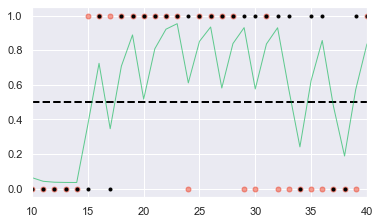

In [31]:
bayes_infer = infer.MarkovInfer(2, 2)

# First, we can check the forward and backward algorithms to be sure that there are no off-by-one errors
bayes_infer.forward_algo(obs_ts, A, B)
bayes_infer.backward_algo(obs_ts, A, B)

fwd_pred = [np.argmax(i) for i in bayes_infer.forward_tracker]
bak_pred = [np.argmax(i) for i in bayes_infer.backward_tracker]
fwd_prob_one = [i[1] for i in bayes_infer.forward_tracker]
bak_prob_one = [i[1] for i in bayes_infer.backward_tracker]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k')

ax.plot(state_ts, 'o', markersize=5, color=sns.xkcd_rgb["tomato"], alpha=0.5)
ax.plot(fwd_pred, 'o', markersize=3, color='k')
ax.plot(fwd_prob_one, linewidth=1.0, color=sns.xkcd_rgb["shamrock"], alpha=0.6)

ax.set_xlim([10,40])

In [4]:
bayes_infer.forward_tracker

[array([0.1, 0.9]),
 array([0.82258065, 0.17741935]),
 array([0.93850267, 0.06149733]),
 array([0.94930683, 0.05069317]),
 array([0.95025037, 0.04974963]),
 array([0.19108237, 0.80891763]),
 array([0.06285892, 0.93714108]),
 array([0.0508128, 0.9491872]),
 array([0.80921948, 0.19078052]),
 array([0.15551381, 0.84448619]),
 array([0.05935503, 0.94064497]),
 array([0.05050527, 0.94949473]),
 array([0.80913222, 0.19086778]),
 array([0.15549429, 0.84450571]),
 array([0.05935314, 0.94064686]),
 array([0.81162342, 0.18837658]),
 array([0.15605291, 0.84394709]),
 array([0.05940716, 0.94059284]),
 array([0.81163851, 0.18836149]),
 array([0.93741381, 0.06258619]),
 array([0.18747606, 0.81252394]),
 array([0.06249761, 0.93750239]),
 array([0.05078104, 0.94921896]),
 array([0.80921047, 0.19078953]),
 array([0.93717047, 0.06282953]),
 array([0.18740849, 0.81259151]),
 array([0.84372941, 0.15627059]),
 array([0.16345666, 0.83654334]),
 array([0.83823415, 0.16176585]),
 array([0.94003857, 0.05996143